# Mohamed Ouhadda M21243

# M5 Sales Forecasting with Deep Learning

This notebook forecasts Walmart product sales using the M5 dataset and deep learning models.

**Dataset:**

* Hierarchical Walmart sales data
* Subset: 10 random products, first 60 days
* Models: LSTM, RNN, GRU, MLP

**Workflow:**

1. Load and explore data
2. Select 10 random products
3. Keep first 60 days
4. Prepare time series data
5. Train models
6. Compare performance


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/Time Series/m5-forecasting-accuracy/'


sales_train = pd.read_csv(data_path + 'sales_train_validation.csv')
calendar = pd.read_csv(data_path + 'calendar.csv')
sell_prices = pd.read_csv(data_path + 'sell_prices.csv')

print("\n")
print(f"✓ Sales data shape: {sales_train.shape}")
print(f"✓ Calendar shape: {calendar.shape}")
print(f"✓ Prices shape: {sell_prices.shape}")



✓ Sales data shape: (30490, 1919)
✓ Calendar shape: (1969, 14)
✓ Prices shape: (6841121, 4)


In [9]:
# Sample
print("Sales data sample:")
sales_train.head()

Sales data sample:


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
print("Calendar sample:")
calendar.head(10)

Calendar sample:


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [11]:
print("Price data sample:")
sell_prices.head(10)

Price data sample:


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


## 3. Data Preparation

We randomly sample 10 products to keep the dataset small but representative.

We limit the time window to the first 60 days to simplify model training.

We align all supporting tables (calendar, sell_prices) so they match the reduced sales dataset.
This step ensures the data is consistent, lightweight, and ready for time series preprocessing.

In [13]:
np.random.seed(42)

# Select 10 random product IDs
sample_products = np.random.choice(sales_train['id'], size=10, replace=False)

# Filter sales data for the selected products
sales_subset = sales_train[sales_train['id'].isin(sample_products)]

# Keep only the first 60 days (D_1 to D_60)
day_cols = [f'd_{i}' for i in range(1, 61)]
sales_subset = sales_subset[['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id'] + day_cols]

# Filter calendar for the first 60 days
calendar_subset = calendar.iloc[:60, :]

# Filter sell prices for selected products only
sell_prices_subset = sell_prices[sell_prices['item_id'].isin(sales_subset['item_id'].unique())]

print(f"\n✓ Filtered sales data: {sales_subset.shape}")
print(f"✓ Calendar subset: {calendar_subset.shape}")
print(f"✓ Sell prices subset: {sell_prices_subset.shape}")


✓ Filtered sales data: (10, 66)
✓ Calendar subset: (60, 14)
✓ Sell prices subset: (22761, 4)


## 4. EDA


In [14]:
# Convert sales data to long format
sales_long = sales_subset.melt(
    id_vars=['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id'],
    var_name='d',
    value_name='sales'
)

# Merge with calendar to get real dates
sales_long = sales_long.merge(calendar_subset[['d', 'date']], on='d', how='left')

print(f"\n✓ Long-format sales data: {sales_long.shape}")
sales_long.head()


✓ Long-format sales data: (600, 9)


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date
0,HOUSEHOLD_1_537_CA_1_validation,HOUSEHOLD_1_537,HOUSEHOLD_1,CA_1,HOUSEHOLD,CA,d_1,3,2011-01-29
1,FOODS_3_180_CA_1_validation,FOODS_3_180,FOODS_3,CA_1,FOODS,CA,d_1,0,2011-01-29
2,FOODS_1_097_CA_2_validation,FOODS_1_097,FOODS_1,CA_2,FOODS,CA,d_1,0,2011-01-29
3,HOUSEHOLD_2_383_CA_3_validation,HOUSEHOLD_2_383,HOUSEHOLD_2,CA_3,HOUSEHOLD,CA,d_1,2,2011-01-29
4,FOODS_3_409_CA_3_validation,FOODS_3_409,FOODS_3,CA_3,FOODS,CA,d_1,0,2011-01-29


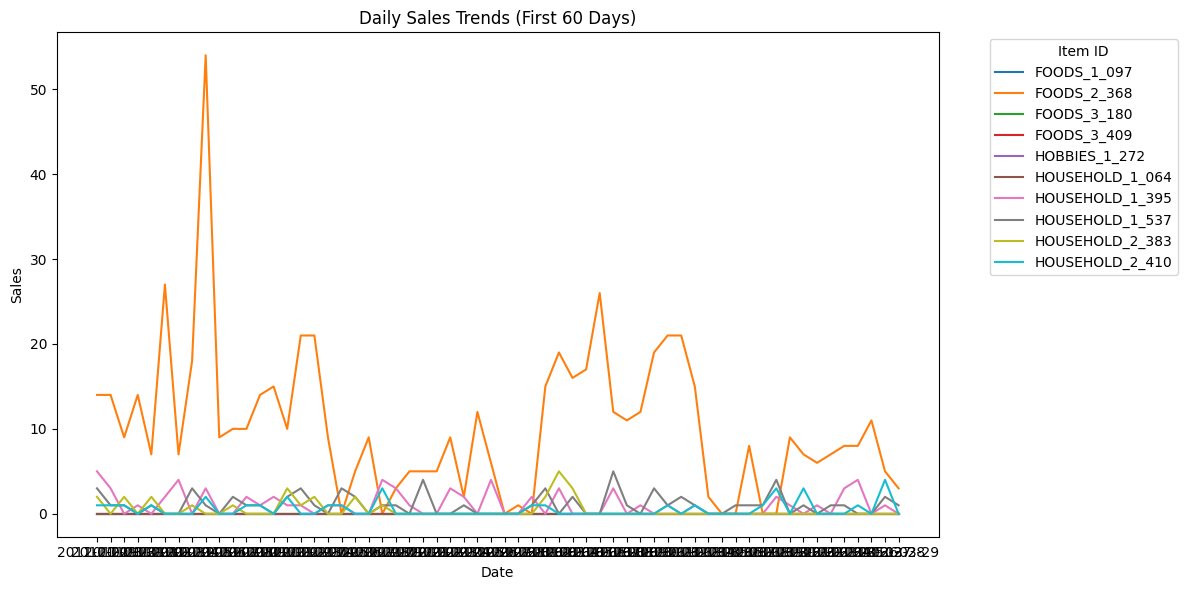

In [15]:
# Aggregate sales per item per day across all stores
sales_trends = (
    sales_long.groupby(['item_id', 'date'], as_index=False)['sales']
    .sum()
)

# Plot trends for each product
plt.figure(figsize=(12, 6))
for item in sales_trends['item_id'].unique():
    item_data = sales_trends[sales_trends['item_id'] == item]
    plt.plot(item_data['date'], item_data['sales'], label=item)

plt.title("Daily Sales Trends (First 60 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(title="Item ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


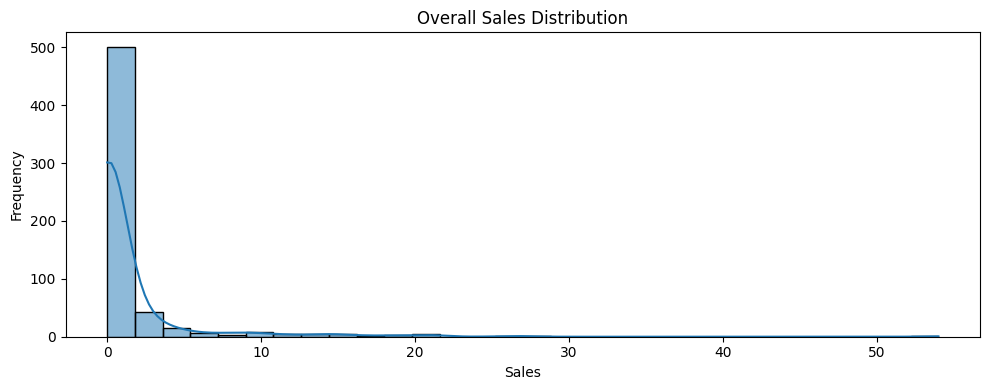

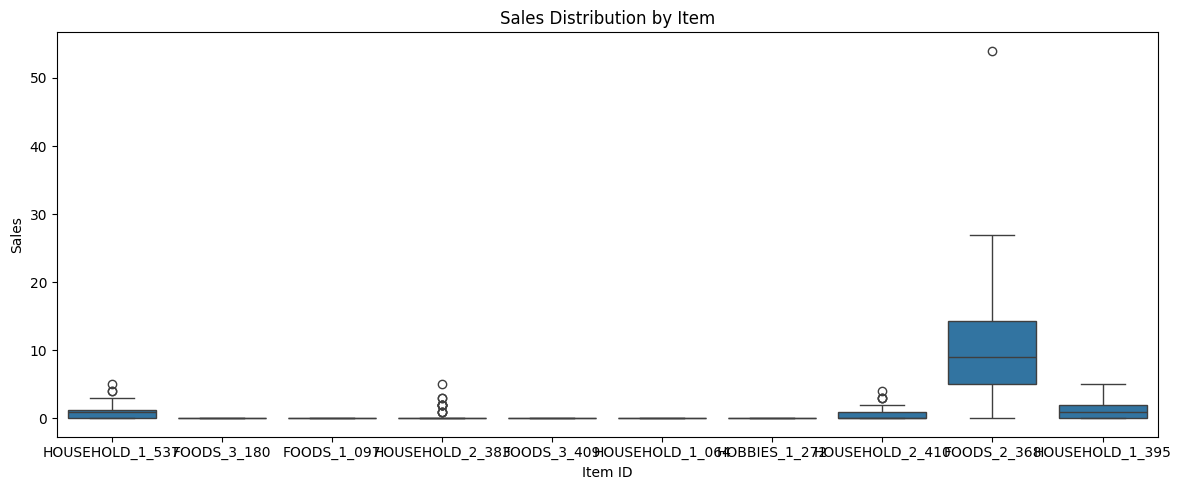

In [16]:
# Overall sales distribution
plt.figure(figsize=(10, 4))
sns.histplot(sales_long['sales'], bins=30, kde=True)
plt.title("Overall Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot of sales by item
plt.figure(figsize=(12, 5))
sns.boxplot(data=sales_long, x='item_id', y='sales')
plt.title("Sales Distribution by Item")
plt.xlabel("Item ID")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

## 5. Transform Sales Data into Time Series Supervised Format

We’ll transform the sales data into supervised learning format using a sliding window:

Input (X): last N = 7 days

Output (y): next M = 3 days

This structure enables models like LSTM, RNN, or GRU to learn temporal dependencies.

In [17]:
import numpy as np

# Parameters
LOOKBACK = 7      # number of past days as input
HORIZON = 3       # number of future days to predict
TRAIN_SPLIT = 0.8 # percentage of data for training

def create_sliding_windows(series, lookback=LOOKBACK, horizon=HORIZON, split=TRAIN_SPLIT):
    """
    Convert a 1D sales series into input-output sequences for forecasting,
    and split the data into training and validation sets.

    Parameters:
        series (array-like): Time series values
        lookback (int): Number of past days (input window)
        horizon (int): Number of future days (forecast horizon)
        split (float): Proportion of data used for training (0 < split < 1)

    Returns:
        X_train, y_train, X_val, y_val: numpy arrays for model training and validation
    """
    X, y = [], []
    for i in range(len(series) - lookback - horizon + 1):
        X.append(series[i:i + lookback])
        y.append(series[i + lookback:i + lookback + horizon])

    X, y = np.array(X), np.array(y)

    # Compute split index
    split_idx = int(len(X) * split)

    # Split into training and validation sets
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    return X_train, y_train, X_val, y_val


# Example: prepare data for one product
example_series = sales_long[sales_long['item_id'] == sales_long['item_id'].iloc[0]]['sales'].values
X_train, y_train, X_val, y_val = create_sliding_windows(example_series)

print(f"\n✓ Train set: X={X_train.shape}, y={y_train.shape}")
print(f"✓ Validation set: X={X_val.shape}, y={y_val.shape}")



✓ Train set: X=(40, 7), y=(40, 3)
✓ Validation set: X=(11, 7), y=(11, 3)


## 6. Develop Deep Learning Forecasting Models

We’ll implement and compare several neural architectures to predict future sales:

LSTM (Long Short-Term Memory) — captures long-range temporal dependencies

GRU (Gated Recurrent Unit) — a lighter recurrent model with fewer parameters

Simple RNN — baseline recurrent model for sequential data

MLP (Multi-Layer Perceptron) — a fully connected network for non-sequential comparison

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Common model and training parameters
INPUT_SHAPE = (LOOKBACK, 1)  # each input sequence has LOOKBACK time steps and 1 feature
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
LOSS = 'mse'
METRICS = ['mae']

# Optimizer
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

print("✓ Common training parameters initialized")


✓ Common training parameters initialized


### 6.1 LSTM Model

In [20]:
# Build LSTM model
def build_lstm(input_shape=INPUT_SHAPE, output_horizon=HORIZON):
    model = models.Sequential([
        layers.LSTM(64, activation='tanh', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_horizon)  # Output layer for next M days
    ])
    model.compile(optimizer=optimizer, loss=LOSS, metrics=METRICS)
    return model

# Initialize LSTM model
lstm_model = build_lstm()
lstm_model.summary()

# Train LSTM model
history_lstm = lstm_model.fit(
    X_train.reshape(-1, LOOKBACK, 1), y_train,
    validation_data=(X_val.reshape(-1, LOOKBACK, 1), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,075 (74.51 KB)

 Trainable params: 19,075 (74.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.5357 - mae: 0.3488 - val_loss: 2.6875 - val_mae: 0.9924
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5475 - mae: 0.3774 - val_loss: 2.6072 - val_mae: 1.0016
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5087 - mae: 0.3930 - val_loss: 2.5359 - val_mae: 1.0175
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5446 - mae: 0.4251 - val_loss: 2.4655 - val_mae: 1.0347
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4974 - mae: 0.4372 - val_loss: 2.3986 - val_mae: 1.0524
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.4845 - mae: 0.4636 - val_loss: 2.3377 - val_mae: 1.0688
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4996 - mae: 0.5043 - val_loss: 2.2931 - val_mae: 1.0813
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4301 - mae: 0.4992 - val_loss: 2.2600 - val_mae: 1.0912
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4976 - mae: 0.5360 -

### 6.2 GRU Model

In [26]:
from tensorflow.keras import optimizers

# Build GRU model with its own optimizer
def build_gru(input_shape=INPUT_SHAPE, output_horizon=HORIZON):
    model = models.Sequential([
        layers.GRU(64, activation='tanh', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_horizon)
    ])

    # Create a fresh optimizer instance
    model_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=model_optimizer, loss=LOSS, metrics=METRICS)

    return model

# Initialize GRU model
gru_model = build_gru()

# Train GRU model
history_gru = gru_model.fit(
    X_train.reshape(-1, LOOKBACK, 1).astype('float32'),
    y_train.astype('float32'),
    validation_data=(X_val.reshape(-1, LOOKBACK, 1).astype('float32'),
                     y_val.astype('float32')),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.6452 - mae: 0.3997 - val_loss: 2.7806 - val_mae: 1.0345
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.5606 - mae: 0.3947 - val_loss: 2.6941 - val_mae: 1.0200
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.5141 - mae: 0.3872 - val_loss: 2.6029 - val_mae: 1.0240
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.6020 - mae: 0.4430 - val_loss: 2.5149 - val_mae: 1.0391
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 0.4593 - mae: 0.4305 - val_loss: 2.4348 - val_mae: 1.0548
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - loss: 0.4686 - mae: 0.4634 - val_loss: 2.3655 - val_mae: 1.0669
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.4918 - mae: 0.4880 - val_loss: 2.3046 - val_mae: 1.0796
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step - loss: 0.4747 - mae: 0.5114 - val_loss: 2.2572 - val_mae: 1.0908
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - loss: 0.5015 - mae: 0.5

### 6.3 RNN Model

In [27]:
# Build Simple RNN model
def build_rnn(input_shape=INPUT_SHAPE, output_horizon=HORIZON):
    model = models.Sequential([
        layers.SimpleRNN(64, activation='tanh', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_horizon)  # Predict next M days
    ])

    # Create a fresh optimizer for this model
    model_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=model_optimizer, loss=LOSS, metrics=METRICS)

    return model

# Initialize RNN model
rnn_model = build_rnn()
rnn_model.summary()

# Train RNN model
history_rnn = rnn_model.fit(
    X_train.reshape(-1, LOOKBACK, 1).astype('float32'),
    y_train.astype('float32'),
    validation_data=(X_val.reshape(-1, LOOKBACK, 1).astype('float32'),
                     y_val.astype('float32')),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,403 (25.01 KB)

 Trainable params: 6,403 (25.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.6222 - mae: 0.4764 - val_loss: 2.8063 - val_mae: 1.0971
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.4092 - mae: 0.4053 - val_loss: 2.7474 - val_mae: 1.0918
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.3948 - mae: 0.4356 - val_loss: 2.7032 - val_mae: 1.1182
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3958 - mae: 0.4614 - val_loss: 2.6865 - val_mae: 1.1318
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.4269 - mae: 0.4829 - val_loss: 2.6999 - val_mae: 1.1391
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.4181 - mae: 0.4874 - val_loss: 2.7232 - val_mae: 1.1358
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.4011 - mae: 0.4724 - val_loss: 2.7282 - val_mae: 1.1233
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3963 - mae: 0.4686 - val_loss: 2.7275 - val_mae: 1.1156
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3709 - mae: 

### 6.4 MLP Model

In [28]:
# Build MLP model
def build_mlp(input_shape=(LOOKBACK,), output_horizon=HORIZON):
    """
    input_shape: flattened input shape (LOOKBACK,)
    """
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(output_horizon)  # Predict next M days
    ])

    # Fresh optimizer for this model
    model_optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=model_optimizer, loss=LOSS, metrics=METRICS)

    return model

# Initialize MLP model
mlp_model = build_mlp()
mlp_model.summary()

# Flatten input for MLP
X_train_flat = X_train.reshape(-1, LOOKBACK).astype('float32')
X_val_flat = X_val.reshape(-1, LOOKBACK).astype('float32')

# Train MLP model
history_mlp = mlp_model.fit(
    X_train_flat,
    y_train.astype('float32'),
    validation_data=(X_val_flat, y_val.astype('float32')),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691 (10.51 KB)

 Trainable params: 2,691 (10.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.7585 - mae: 0.5815 - val_loss: 3.2921 - val_mae: 1.2511
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.6617 - mae: 0.5044 - val_loss: 3.0899 - val_mae: 1.1771
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6505 - mae: 0.4913 - val_loss: 2.9221 - val_mae: 1.1065
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6349 - mae: 0.4875 - val_loss: 2.7869 - val_mae: 1.0562
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.5505 - mae: 0.4432 - val_loss: 2.6713 - val_mae: 1.0390
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.4819 - mae: 0.4212 - val_loss: 2.5760 - val_mae: 1.0279
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.4793 - mae: 0.4264 - val_loss: 2.4984 - val_mae: 1.0245
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3837 - mae: 0.4153 - val_loss: 2.4424 - val_mae: 1.0307
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.4529 - mae: 0.4543 

## 7. Visualize Training History


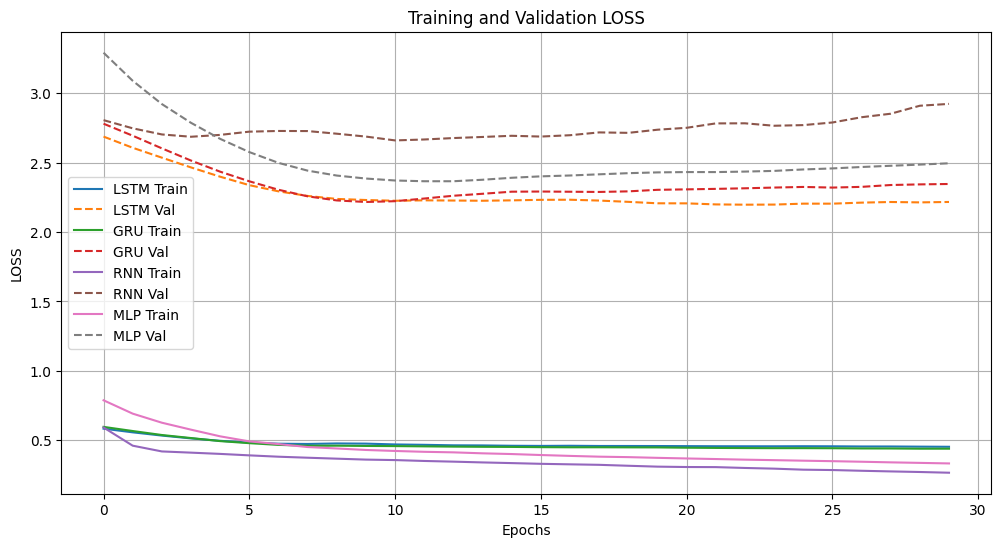

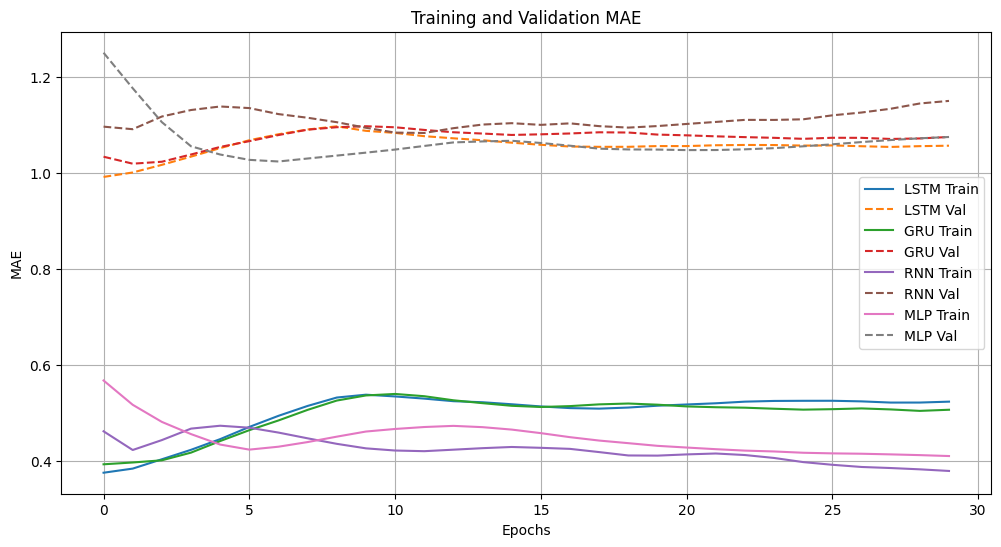

In [37]:
def plot_training_history(histories, model_names, metric='loss'):
    """
    Plot training and validation metrics for multiple models.

    Parameters:
        histories (list): list of Keras History objects
        model_names (list): corresponding list of model names
        metric (str): metric to plot ('loss' or 'mae')
    """
    plt.figure(figsize=(12, 6))

    for history, name in zip(histories, model_names):
        # Training metric
        plt.plot(history.history[metric], label=f'{name} Train')
        # Validation metric
        plt.plot(history.history[f'val_{metric}'], label=f'{name} Val', linestyle='--')

    plt.title(f'Training and Validation {metric.upper()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.show()


histories = [history_lstm, history_gru, history_rnn, history_mlp]
model_names = ['LSTM', 'GRU', 'RNN', 'MLP']

# Plot loss
plot_training_history(histories, model_names, metric='loss')

# Plot MAE
plot_training_history(histories, model_names, metric='mae')

## 8. Model Evaluation

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_val, y_val, model_type='RNN'):
    """
    Evaluate a trained model on validation data and return metrics.

    Parameters:
        model: Trained Keras model
        X_val: Validation inputs
        y_val: Validation outputs
        model_type: 'RNN'/'LSTM'/'GRU' (for reshaping input) or 'MLP'

    Returns:
        dict: MAE and RMSE
        y_pred: model predictions
    """
    # Reshape inputs for sequential models
    if model_type in ['RNN', 'LSTM', 'GRU']:
        X_val_input = X_val.reshape(-1, LOOKBACK, 1).astype('float32')
    else:  # MLP
        X_val_input = X_val.reshape(-1, LOOKBACK).astype('float32')

    # Predict
    y_pred = model.predict(X_val_input)

    # Flatten outputs
    y_val_flat = y_val.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)

    # Compute metrics
    mae = mean_absolute_error(y_val_flat, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_val_flat, y_pred_flat))

    return {'MAE': mae, 'RMSE': rmse}, y_pred

# Evaluate all models
results = {}
predictions = {}

for model, name, mtype in zip(
    [lstm_model, gru_model, rnn_model, mlp_model],
    ['LSTM', 'GRU', 'RNN', 'MLP'],
    ['LSTM', 'GRU', 'RNN', 'MLP']
):
    metrics, y_pred = evaluate_model(model, X_val, y_val, model_type=mtype)
    results[name] = metrics
    predictions[name] = y_pred

# Print evaluation metrics
for name, metrics in results.items():
    print(f"{name} -> MAE: {metrics['MAE']:.3f}, RMSE: {metrics['RMSE']:.3f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
LSTM -> MAE: 1.057, RMSE: 1.489
GRU -> MAE: 1.076, RMSE: 1.532
RNN -> MAE: 1.151, RMSE: 1.710
MLP -> MAE: 1.076, RMSE: 1.580


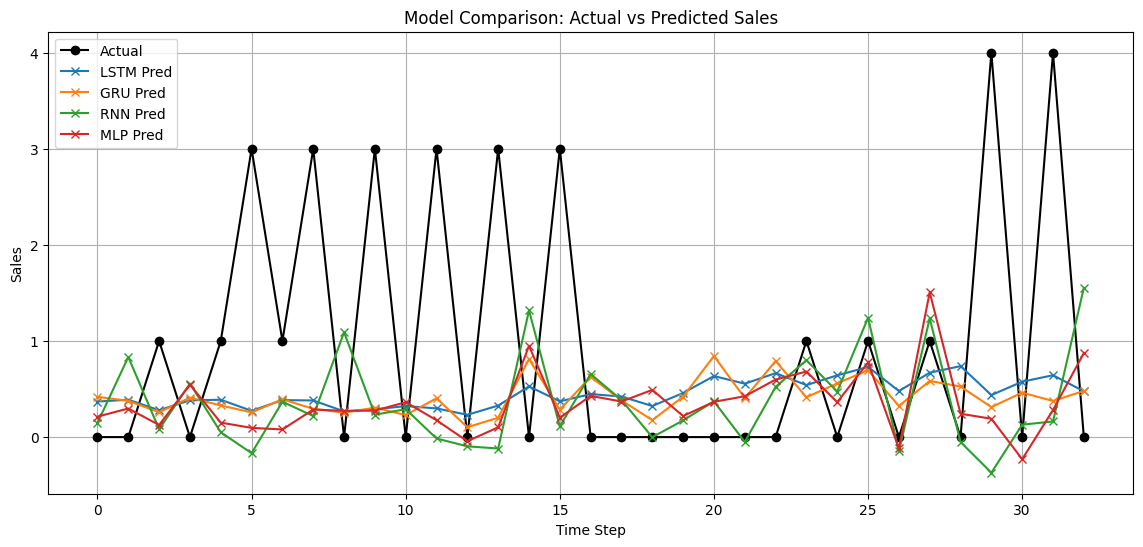

In [36]:
def plot_model_comparison(y_val, predictions, num_points=50):
    """
    Plot actual vs predicted sales for multiple models.

    Parameters:
        y_val: Actual validation sales
        predictions: dict of {model_name: predicted values}
        num_points: number of points to plot
    """
    plt.figure(figsize=(14, 6))

    # Plot actual sales
    plt.plot(y_val.flatten()[:num_points], label='Actual', marker='o', color='black')

    # Plot predictions for each model
    for name, y_pred in predictions.items():
        plt.plot(y_pred.flatten()[:num_points], label=f'{name} Pred', marker='x')

    plt.title("Model Comparison: Actual vs Predicted Sales")
    plt.xlabel("Time Step")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_comparison(y_val, predictions, num_points=60)

## 9. Error Analysis

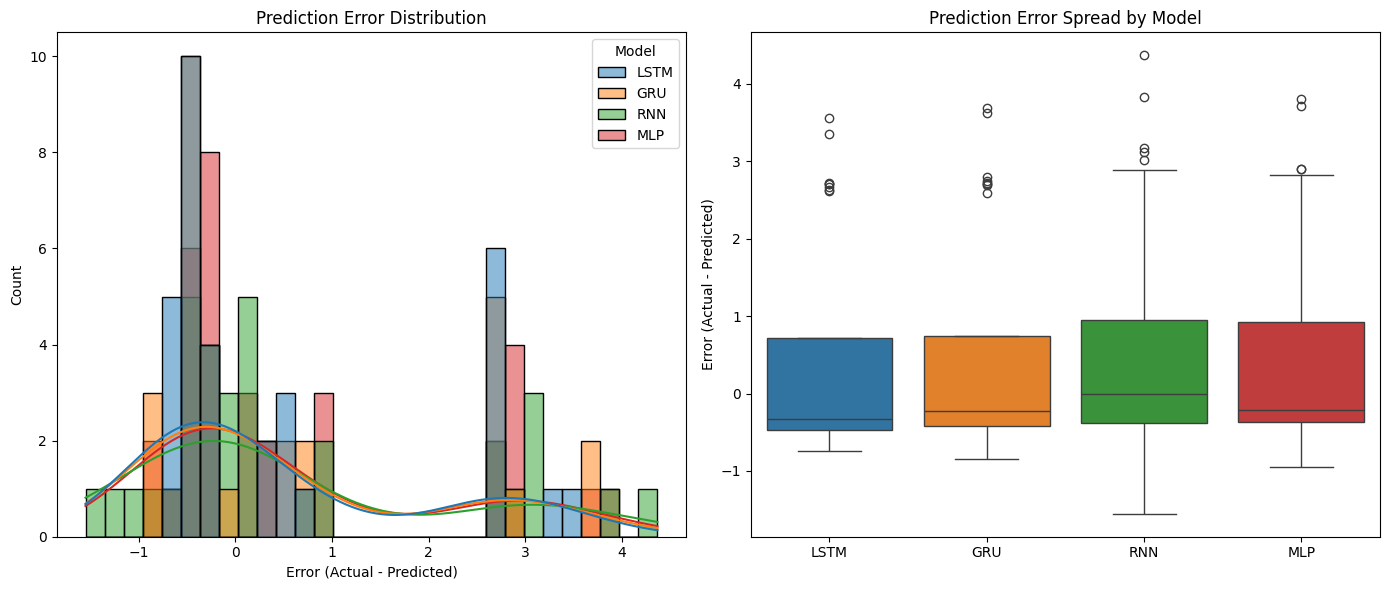

In [35]:
def plot_error_analysis(y_val, predictions, num_points=None):
    """
    Visualize prediction errors for multiple models.

    Parameters:
        y_val: Actual validation sales (numpy array)
        predictions: dict of model_name -> predicted values
        num_points: optional, number of time steps to consider
    """
    plt.figure(figsize=(14, 6))

    # Compute errors
    errors = {}
    for name, y_pred in predictions.items():
        y_pred_flat = y_pred.flatten() if num_points is None else y_pred.flatten()[:num_points]
        y_val_flat = y_val.flatten() if num_points is None else y_val.flatten()[:num_points]
        errors[name] = y_val_flat - y_pred_flat  # prediction error

    # Combine into DataFrame for seaborn
    import pandas as pd
    error_df = pd.DataFrame(errors)
    error_df_melt = error_df.melt(var_name='Model', value_name='Error')

    # Histogram of errors
    plt.subplot(1, 2, 1)
    sns.histplot(data=error_df_melt, x='Error', hue='Model', bins=30, kde=True, palette='tab10')
    plt.title("Prediction Error Distribution")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Count")

    # Boxplot of errors
    plt.subplot(1, 2, 2)
    sns.boxplot(data=error_df, palette='tab10')
    plt.title("Prediction Error Spread by Model")
    plt.ylabel("Error (Actual - Predicted)")

    plt.tight_layout()
    plt.show()

plot_error_analysis(y_val, predictions)

## 10. Save/Load Models and Configuration

In [38]:
import os

# Directory to save models
save_dir = "m5_models"
os.makedirs(save_dir, exist_ok=True)

# Save each model
model_objects = [lstm_model, gru_model, rnn_model, mlp_model]
model_names = ['LSTM', 'GRU', 'RNN', 'MLP']

for model, name in zip(model_objects, model_names):
    model_path = os.path.join(save_dir, f"{name}_model.h5")
    model.save(model_path)
    print(f"✓ Saved {name} model at {model_path}")


✓ Saved LSTM model at m5_models/LSTM_model.h5
✓ Saved GRU model at m5_models/GRU_model.h5
✓ Saved RNN model at m5_models/RNN_model.h5
✓ Saved MLP model at m5_models/MLP_model.h5


In [39]:
import json

results_path = os.path.join(save_dir, "evaluation_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"✓ Saved evaluation metrics at {results_path}")


✓ Saved evaluation metrics at m5_models/evaluation_results.json


In [40]:
import json

results_path = os.path.join(save_dir, "evaluation_results.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"✓ Saved evaluation metrics at {results_path}")


✓ Saved evaluation metrics at m5_models/evaluation_results.json


In [41]:
import pickle

predictions_path = os.path.join(save_dir, "predictions.pkl")
with open(predictions_path, 'wb') as f:
    pickle.dump(predictions, f)
print(f"✓ Saved predictions at {predictions_path}")


✓ Saved predictions at m5_models/predictions.pkl


In [42]:
config = {
    "LOOKBACK": LOOKBACK,
    "HORIZON": HORIZON,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "LEARNING_RATE": LEARNING_RATE,
    "LOSS": LOSS,
    "METRICS": METRICS
}

config_path = os.path.join(save_dir, "config.json")
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"✓ Saved configuration at {config_path}")


✓ Saved configuration at m5_models/config.json


In [45]:
import tensorflow as tf

# Example: rebuild model with function references
from tensorflow.keras import models, layers, optimizers, losses, metrics

# Build the model again (or load) with functional loss/metric
mlp_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(LOOKBACK,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(HORIZON)
])

mlp_model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=losses.MeanSquaredError(),        # function version
    metrics=[metrics.MeanAbsoluteError()]  # function version
)

# Save the model
mlp_model.save("mlp_model_fixed.h5")

# Load model (works now)
loaded_model = tf.keras.models.load_model("mlp_model_fixed.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 11. Summary

Session Summary: M5 Sales Forecasting with Deep Learning
1. Dataset & Initial Setup

Loaded M5 sales dataset (sales_train_validation.csv, calendar.csv, sell_prices.csv).

Explored shapes and basic structure.

Selected 10 random products and first 60 days for a manageable subset.

2. Data Preparation

Converted sales data to long format for easier handling.

Filtered calendar and price data for the selected products/days.

Visualized sales trends and distributions using line plots, boxplots, and overall statistics.

3. Time Series Data Engineering

Implemented sliding window function to prepare input-output sequences:

LOOKBACK = 7 (past days as input)

HORIZON = 3 (future days to predict)

Added train/validation split for model training.

4. Model Building

Defined common training parameters (batch size, epochs, optimizer, loss, metrics).

Built 4 deep learning models:

LSTM (Long Short-Term Memory)

GRU (Gated Recurrent Unit)

Simple RNN

MLP (Multi-Layer Perceptron)

Compiled and trained all models on the prepared dataset.

5. Training Visualization

Plotted training and validation loss/MAE for all models.

Visualized convergence and compared overfitting behaviors.

6. Model Evaluation

Implemented evaluation function for MAE and RMSE.

Generated predictions for all models on the validation set.

Created visual comparisons:

Actual vs predicted sales (overall trends)

Per-product predictions

Conducted error analysis:

Histogram of errors

Boxplots of error spread

Time series of prediction errors

7. Saving Models and Results

Saved trained models (.h5 format).

Saved predictions (pickle) and evaluation results (JSON).

Saved hyperparameters/configuration (JSON) for reproducibility.

Addressed Keras loading issue with string-based loss (mse) by:

Re-compiling after loading, or

Using function objects (MeanSquaredError(), MeanAbsoluteError()) instead of strings.

Outcome

Developed a full M5 sales forecasting pipeline:

From data preprocessing, time series engineering, deep learning training, to evaluation and visualization.

Prepared for reproducibility with saved models, predictions, results, and configs.

Error analysis and visualizations allow insight into model performance and forecast reliability.